# Learning and economies-of-scale effects on power generation technology cost improvements

Yoga W. Pratama, Matthew J. Gidden, Jenna Greene, Andrew Zaiser, Gregory Nemet, Keywan Riahi

In [1]:
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import matplotlib.lines as mlines
from matplotlib.ticker import AutoLocator, MultipleLocator, MaxNLocator
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings('ignore')


## Data collection and pre-estimate calculation

In [2]:
# READING DATA FROM EXCEL
data = {
    'Nuclear':{
        'Nuclear pre-1967':[],
        'Nuclear post-1967':[]},
    'Coal':{
        'Coal':[]},
    'Gas':{
        'Gas-OC':[],
        'Gas-CC':[]
    },
    'Geothermal':{
        'Geothermal':[]
    },
    'Wind':{
        'Wind Onshore':[],
        'Wind Offshore':[],
    },
    'Solar':{
        'Solar PV (Utility)':[],
        'Solar CSP':[],
    }
    
}

technologies = [k1 for k in data.keys() for k1 in data[k]]

for k,v in data.items():
    for k1,v1 in v.items():
        df = pd.read_excel('data/all_technologies-CM2024.xlsx',
                   sheet_name=k1, header=[0],index_col=[0], 
                   engine='openpyxl')
        
        # data[k][k1] = df

        df['Unit Size Frontier'] = 0
        df['Project Size Frontier'] = 0
        for y in df.index:
            y0 = df.index[0]
            df['Unit Size Frontier'][y] = max(df['Unit Size'].loc[y0:y])
            df['Project Size Frontier'][y] = max(df['Project Size'].loc[y0:y])
            
        for c in df.columns[0:5]:
            df['Log_normRef_'+c] = [np.log10(df.loc[r,c]/df.loc[df.index[0],c])
                                    for r in df.index]
        for c in ['Unit Size','Project Size','Capex']:
            df['Log_'+c] = [np.log10(df.loc[r,c])
                            for r in df.index]
        
        # adding size change parameter
        usize_ratio = df['Unit Size'].diff()
        psize_ratio = df['Project Size'].diff()
        df['Unit Size Change'] = usize_ratio
        df['Project Size Change'] = psize_ratio
        
        data[k][k1] = df
        

In [3]:
data["Nuclear"]["Nuclear pre-1967"].head(10)

,Cumulative Capacity,Cumulative Units,Cumulative Projects,Unit Size,Project Size,Capex,Unit Size Frontier,Project Size Frontier,Log_normRef_Cumulative Capacity,Log_normRef_Cumulative Units,Log_normRef_Cumulative Projects,Log_normRef_Unit Size,Log_normRef_Project Size,Log_Unit Size,Log_Project Size,Log_Capex,Unit Size Change,Project Size Change
Year,,,,,,,,,,,,,,,,,,
1954,60.0,1,1,60.0,1.000000,6814,60.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.778151,0.000000,3.833402,NaN,NaN
1956,897.0,9,9,115.4,1.000000,2502,115.4,1.000000,1.174641,0.954243,0.954243,0.284055,0.000000,2.062206,0.000000,3.398287,55.4,0.000000
1957,2733.0,22,22,141.2,1.000000,8512,141.2,1.000000,1.658488,1.342423,1.342423,0.371683,0.000000,2.149835,0.000000,3.930032,25.8,0.000000
1958,3194.0,27,27,92.2,1.000000,6294,141.2,1.000000,1.726184,1.431364,1.431364,0.186580,0.000000,1.964731,0.000000,3.798927,-49.0,0.000000
1959,4170.0,34,31,139.4,1.666667,2889,141.2,1.666667,1.841985,1.531479,1.491362,0.366112,0.221849,2.144263,0.221849,3.460748,47.2,0.666667
1960,5180.0,45,42,91.8,1.000000,4221,141.2,1.666667,1.936179,1.653213,1.623249,0.184691,0.000000,1.962843,0.000000,3.625415,-47.6,-0.666667
1961,6709.0,52,49,218.4,1.000000,3742,218.4,1.666667,2.048507,1.716003,1.690196,0.561101,0.000000,2.339253,0.000000,3.573104,126.6,0.000000
1962,8088.0,60,55,172.4,1.285714,3594,218.4,1.666667,2.129690,1.778151,1.740363,0.458386,0.109144,2.236537,0.109144,3.555578,-46.0,0.285714
1963,9810.0,65,60,344.4,1.000000,1959,344.4,1.666667,2.213518,1.812913,1.778151,0.758912,0.000000,2.537063,0.000000,3.292034,172.0,-0.285714


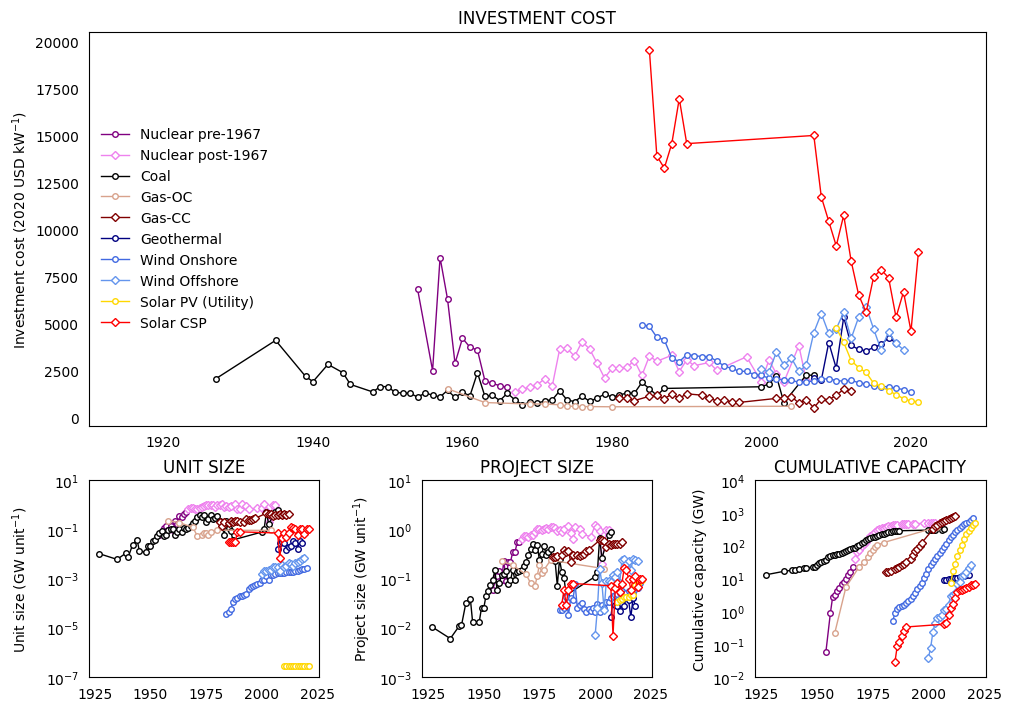

In [4]:
## USE THIS TO SEE PROJECT AND UNIT SIZES ONLY
# LIST OF FIGURE PARAMETERS
techs = ['Nuclear pre-1967','Nuclear post-1967',
         'Coal','Gas T','Gas CC',
         'Geothermal',
         'Wind Onshore','Wind Offshore',
         'Solar PV (Utility)','Solar CSP',
          ]
colors = ['purple','violet','black','#d8a28c','#800000',
          'navy','royalblue','cornflowerblue',
          'gold','red']
markers = ['o','D','o','o','D',
           'o','o','D',
           'o','D']

# GENERATE ADDITIONAL INPUT FOR FIGURE SETUP
fig_titles = ["INVESTMENT COST", "UNIT SIZE", "PROJECT SIZE", "CUMULATIVE CAPACITY"]
parameters = ['Capex','Unit Size','Project Size','Cumulative Capacity']

# GENERATE FIGURE 7

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(layout="constrained", figsize=(10,7))

gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0:2, 0:3])
ax2 = fig.add_subplot(gs[2:3, 0])
ax3 = fig.add_subplot(gs[2:3, 1])
ax4 = fig.add_subplot(gs[2:3, 2])

axs = [ax1,ax2,ax3,ax4]

for p in range(len(parameters)):
    axs[p].set_title(fig_titles[p], size=12)
    t = 0
    for k,v in data.items():
        for k1 in v.keys():
            df = v[k1]
            x = df.index
            if parameters[p] == 'Capex':
                y = df[parameters[p]]
            elif parameters[p] == 'Project Size':
                y = df[parameters[p]].mul(df['Unit Size']/1000)
            else:
                y = df[parameters[p]]/1000
            plotv = axs[p].plot(x,y,
                            color=colors[t],lw=1,
                            marker=markers[t], mfc='w',ms=4, 
                            label=k1)
            t=t+1
            # print(k1)
            axs[p].xaxis.set_ticks_position('none') 
            axs[p].yaxis.set_ticks_position('none') 
            

axs[0].set_xlim(1910,2030)
axs[0].set_xticks([*range(1920,2030,20)])
axs[0].set_ylabel('Investment cost (2020 USD kW$^{-1}$)')
axs[1].set_ylim(10**(-7),10)
axs[1].set_yscale('log')
axs[1].set_ylabel('Unit size (GW unit$^{-1}$)')
axs[2].set_yscale('log')
axs[2].set_ylabel('Project size (GW unit$^{-1}$)')
axs[2].set_ylim(0.001,10)
axs[3].set_yscale('log')
axs[3].set_ylabel('Cumulative capacity (GW)')
axs[3].set_ylim(0.01,10000)

allspines = []#,'bottom']
for a in axs:
    a.grid(visible=False, which='both', axis='y') # make grid feasible or hidden
    for s in allspines:
        a.spines[s].set_visible(False) #It works

axs[0].legend(frameon=False, loc=6, ncol=1)

# Aligning y labels
fig.align_ylabels(axs[0:2])
fig.savefig('figure/fig7_capex size data.jpg', transparent=True, dpi=600)

plt.show()

## "Learning" to Scale-up

optimal  estimates for  Wind Onshore


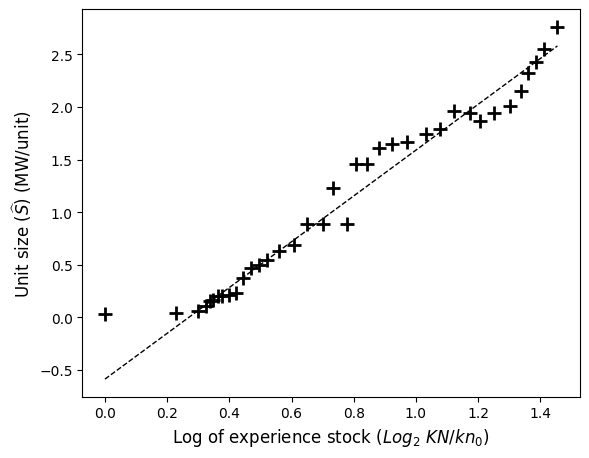

In [5]:
# GRANULAR ONE-FACTOR LEARNING (GOFL)

alpha_list = []
Sref_gofl_list = []

tech = 'Wind Onshore'

df = data['Wind']['Wind Onshore'].copy()

## Additional data definition
log_nr_data = df['Log_normRef_Cumulative Units'].to_dict()      # creating list of units #
sr_data = df['Unit Size'].to_dict()        # creating dictionary of units size


## Declare model's name
model   = ConcreteModel('Parameter Estimate')

## Define sets ##
model.n = Set(initialize=list(log_nr_data.keys()), doc='Units number')

## Define data and parameters ## 
model.log_nr    = Param(model.n, initialize=log_nr_data, doc='Units # data')
model.sr        = Param(model.n, initialize=sr_data, doc='Units size data')

## Define variables ##
model.Sref      = Var(bounds=(None,None), doc='Investment cost at reference units # and size')
model.Error     = Var(model.n, bounds=(None,None), doc='Error, i.e., delta between data and calculation')
model.Error_pos = Var(model.n, bounds=(0.0,None), doc='x+ variable to make absolute number for x')
model.Error_neg = Var(model.n, bounds=(0.0,None), doc='x- variable to make absolute number for x')
model.Alpha     = Var(bounds=(0.0,None), doc='Unit scale up rate parameter')

## Define constraints ##
def error_rule(model, n):
  return model.Error[n] == (model.sr[n] 
                            - model.Sref - model.Alpha * model.log_nr[n]
                           )
model.error = Constraint(model.n, rule=error_rule, doc='Error calculation')

def errorabs_rule(model, n):
  return model.Error[n] == model.Error_pos[n] - model.Error_neg[n]
model.errorabs = Constraint(model.n, rule=errorabs_rule, doc='Absolute error calculation')

## Define objective functions ##
def objective_rule(model):
  return (1/len(df))*sum(((model.Error_pos[n] + model.Error_neg[n])) for n in model.n) # Least square
model.objective = Objective(rule=objective_rule, sense=minimize, doc='Objective function')

# This is an optional code path that allows the script to be run outside of
# pyomo command-line.  
if __name__ == '__main__':
    # This emulates what the pyomo command-line tools does
    from pyomo.opt import SolverFactory
    import pyomo.environ
    opt = SolverFactory("gams")
    opt.options['solver'] = 'cplex'
    results = opt.solve(model)
    print(results.solver.termination_condition,' estimates for ',tech)

error_avg       = model.objective(value)
alpha           = model.Alpha(value)
Sref_granular   = (model.Sref(value))

# collecting parameters data into list
alpha_list.append(alpha)
Sref_gofl_list.append(Sref_granular)

## plottings
# Generate colormap values based on y
fig, axs = plt.subplots(figsize=(6,(6/7)*5.47))

layer_1 = axs.scatter(list(log_nr_data.values()), list(sr_data.values()), 
                          s=100, marker='+', lw=2,
                          fc='black',
                          label=tech,zorder=2)

est_granular  = [model.Sref(value) + alpha * log_nr_data[x] for x in df.index.to_list()]
layer_2 = axs.plot(list(log_nr_data.values()),est_granular,c='black',
                   lw=1,zorder=1,ls='--') 


axs.set_ylabel('Unit size ($\widehat{S}$) (MW/unit)', size=12)
axs.set_xlabel('Log of experience stock ($Log_{2} \ KN/kn_{0}$)', size=12)


# Remove the top and right spines
sides = ['top','bottom','left','right']
for s in sides:
    axs.spines[s].set_visible(True)

# Remove the left and bottom ticks
axs.tick_params(axis='both', which='both', 
                bottom=True, top=False, left=True, right=False)

# Rotate the tick labels and set their alignment.
plt.setp(axs.get_xticklabels(minor=False), rotation=0, ha="center",
             rotation_mode="anchor")
#axs.grid(True)
plt.tight_layout()
fig.savefig('figure/fig1_illustration_b.jpg', dpi=600,transparent=True)
plt.show()

### Scale-up rate table
#### Unit level:

In [6]:
df_usrate = {'Technology':[],
            'Scale-up rate':[],
            'R-squared':[]}

# fig, axs = plt.subplots(nrows=3,ncols=4, figsize=(11,7))
counter = 0
for k,v in data.items():
    for k1,v1 in v.items():
        if k1 != 'All':

            df = data[k][k1]
            
            # Calculate IQR parameters
            speed = df['Unit Size Frontier'].diff().div(df['Log_normRef_Cumulative Units'].diff())
            q1 = speed.quantile(0.25)
            q3 = speed.quantile(0.75)
            iqr = q3-q1

            # Excluding outliers
            new_speed = speed.loc[speed >= q1-1.5*iqr]
            new_speed = new_speed.loc[new_speed <=q3+1.5*iqr]
            index = new_speed.index

            df_red = df.reindex(index)

            x = df_red['Log_normRef_Cumulative Units'].to_list()
            y = df_red['Unit Size Frontier'].to_list()
            
            x_exc = [df['Log_normRef_Cumulative Units'].loc[e] for e in df.index if e not in index]
            y_exc = [df['Unit Size Frontier'].loc[e] for e in df.index if e not in index]


            # Fit a polynomial of degree 1 (linear fit)
            coefficients = np.polyfit(x, y, 1)

            # Calculate the predicted values and mean of the observed values
            y_pred = np.polyval(coefficients, x)
            y_mean = np.mean(y)

            # Calculate the total sum of squares (TSS) and residual sum of squares (RSS)
            tss = np.sum((y - y_mean)**2)
            rss = np.sum((y - y_pred)**2)

            # Calculate R-squared
            r_squared = 1 - (rss / tss)

            df_usrate['Technology'] = df_usrate['Technology'] + [k1]
            df_usrate['Scale-up rate'] = df_usrate['Scale-up rate'] + [np.round(coefficients[0],2)]
            df_usrate['R-squared'] = df_usrate['R-squared'] + [np.round(r_squared,2)]

            # Specify row column caunter
            row = int(np.floor(counter/4))
            col = counter - row*4
            counter = counter+1

            #axs[row,col].scatter(x,y,marker='o', edgecolors='red', c='None')
            #axs[row,col].scatter(x_exc,y_exc,marker='x', c='red')
            #axs[row,col].scatter(df['Log_normRef_Cumulative Units'].to_list(),
            #                     df['Unit Size'].to_list(),marker='^', edgecolors='blue', c='None')
            #axs[row,col].plot(x,y_pred,c='red',lw=2)
            #axs[row,col].set_title(k1)
            #axs[row,col].set_ylim(-0.05*max(y),1.2*max(y))

#axs[2,2].axis('off')
#axs[2,3].axis('off')

#plt.tight_layout()
#plt.show()

df_usrate = pd.DataFrame(data=df_usrate).set_index('Technology')

#### Project level:

In [7]:
df_psrate = {'Technology':[],
            'Scale-up rate':[],
            'R-squared':[]}

# fig, axs = plt.subplots(nrows=3,ncols=4, figsize=(11,7))
counter = 0
for k,v in data.items():
    for k1,v1 in v.items():
        if k1 != 'Dummy so all can be included':

            df = data[k][k1]

            # Calculate IQR parameters
            speed = df['Project Size Frontier'].diff().div(df['Log_normRef_Cumulative Units'].diff())
            q1 = speed.quantile(0.25)
            q3 = speed.quantile(0.75)
            iqr = q3-q1

            # Excluding outliers
            new_speed = speed.loc[speed >= q1-1.5*iqr]
            new_speed = new_speed.loc[new_speed <=q3+1.5*iqr]
            index = new_speed.index

            df_red = df.reindex(index)

            x = df_red['Log_normRef_Cumulative Units'].to_list()
            y = df_red['Project Size Frontier'].to_list()
            
            x_exc = [df['Log_normRef_Cumulative Units'].loc[e] for e in df.index if e not in index]
            y_exc = [df['Project Size Frontier'].loc[e] for e in df.index if e not in index]


            # Fit a polynomial of degree 1 (linear fit)
            coefficients = np.polyfit(x, y, 1)

            # Calculate the predicted values and mean of the observed values
            y_pred = np.polyval(coefficients, x)
            y_mean = np.mean(y)

            # Calculate the total sum of squares (TSS) and residual sum of squares (RSS)
            tss = np.sum((y - y_mean)**2)
            rss = np.sum((y - y_pred)**2)

            # Calculate R-squared
            r_squared = 1 - (rss / tss)

            df_psrate['Technology'] = df_psrate['Technology'] + [k1]
            df_psrate['Scale-up rate'] = df_psrate['Scale-up rate'] + [np.round(coefficients[0],2)]
            df_psrate['R-squared'] = df_psrate['R-squared'] + [np.round(r_squared,2)]

            # Specify row column caunter
            row = int(np.floor(counter/4))
            col = counter - row*4
            counter = counter+1

            #axs[row,col].scatter(x,y,marker='o', edgecolors='red', c='None')
            #axs[row,col].scatter(x_exc,y_exc,marker='x', c='red')
            #axs[row,col].scatter(df['Log_normRef_Cumulative Units'].to_list(),
            #                     df['Project Size'].to_list(),marker='^', edgecolors='blue', c='None')
            #axs[row,col].plot(x,y_pred,c='red',lw=2)
            #axs[row,col].set_title(k1)
            #axs[row,col].set_ylim(-0.05*max(y),1.2*max(y))

#axs[2,2].axis('off')
#axs[2,3].axis('off')

#plt.tight_layout()
#plt.show()

df_psrate = pd.DataFrame(data=df_psrate).set_index('Technology')

# Scale-up Rates of Technologies
## Unit level:

In [8]:
df_usrate[["Scale-up rate"]]

,Scale-up rate
Technology,
Nuclear pre-1967,338.46
Nuclear post-1967,576.36
Coal,1442.26
Gas-OC,0.00
Gas-CC,224.86
Geothermal,67.46
Wind Onshore,2.17
Wind Offshore,2.12
Solar PV (Utility),0.00


## Project level:

In [9]:
df_psrate[["Scale-up rate"]]

,Scale-up rate
Technology,
Nuclear pre-1967,0.89
Nuclear post-1967,0.59
Coal,1.14
Gas-OC,1.05
Gas-CC,0.00
Geothermal,3.39
Wind Onshore,-0.00
Wind Offshore,-0.00
Solar PV (Utility),108401.72


**Updating the data:**

In [10]:
for k,v in data.items():
    for k1 in v.keys():
        df = data[k][k1].copy()
        df['Log_Cunit'] = np.log10(df['Unit Size Frontier'].div(df['Unit Size Frontier'].sub(df['Unit Size Frontier'].diff())
                           .add(df['Log_normRef_Cumulative Units'].diff().mul(df_usrate.loc[k1,'Scale-up rate']))))
        df['Log_Cunit'].loc[df['Log_Cunit'] <=0] = 0
        df['Log_Cproject'] = np.log10(df['Project Size Frontier'].div(df['Project Size Frontier'].sub(df['Project Size Frontier'].diff())
                              .add(df['Log_normRef_Cumulative Units'].diff().mul(df_psrate.loc[k1,'Scale-up rate']))))
        df['Log_Cproject'].loc[df['Log_Cproject'] <=0] = 0
        
        # Add cumulative C
        df['Cumulative Log_Cunit'] = df['Log_Cunit'].cumsum()
        df['Cumulative Log_Cproject'] = df['Log_Cproject'].cumsum()
        
        if k1 in ['Nuclear pre-1967', 'Wind Offshore','Wind Onshore','Geothermal','Solar CSP']:
                df['Cumulative Log_Cunit'] = 0
        if k1 in ['Gas-OC', 'Solar PV (Utility)', 'Nuclear pre-1967', 'Solar CSP','Geothermal',]:
                df['Cumulative Log_Cproject'] = 0
        
        data[k][k1] = df.dropna() # data ready

## Parameters estimation
#### One factor learning:

In [11]:
df_1flrate = {'Technology':[],
            'Learning par.':[],
            'Learning rate':[],
            'Capex ref.':[],
            'R-squared':[]}

#fig, axs = plt.subplots(nrows=3,ncols=4, figsize=(11,7))
counter = 0
for k,v in data.items():
    for k1,v1 in v.items():
        if k1 != 'Dummy so all can be included':
            
            df = data[k][k1]

            x = df['Log_normRef_Cumulative Capacity'].to_list()
            y = df['Log_Capex'].to_list()
            x_plot = df['Cumulative Capacity'].to_list()
            
            # Fit a polynomial of degree 1 (linear fit)
            coefficients = np.polyfit(x, y, 1)

            # Calculate the predicted values and mean of the observed values
            y_pred = np.polyval(coefficients, x)
            y_mean = np.mean(y)

            # Calculate the total sum of squares (TSS) and residual sum of squares (RSS)
            tss = np.sum((y - y_mean)**2)
            rss = np.sum((y - y_pred)**2)

            # Calculate R-squared
            r_squared = 1 - (rss / tss)

            df_1flrate['Technology'] = df_1flrate['Technology'] + [k1]
            df_1flrate['Learning par.'] = df_1flrate['Learning par.'] + [np.round(-coefficients[0],2)]
            df_1flrate['Learning rate'] = df_1flrate['Learning rate'] + [100*np.round(1-2**(coefficients[0]),3)]
            df_1flrate['Capex ref.'] = df_1flrate['Capex ref.'] + [np.int32(10**coefficients[1])]
            df_1flrate['R-squared'] = df_1flrate['R-squared'] + [np.round(r_squared,2)]

            # Specify row column caunter
            row = int(np.floor(counter/4))
            col = counter - row*4
            counter = counter+1

            #axs[row,col].scatter(x_plot,[10**e for e in y],marker='o', edgecolors='red', c='None')
            #axs[row,col].plot(x_plot,[10**e for e in y_pred],c='red',lw=2)
            #axs[row,col].set_title(k1)
            #axs[row,col].set_ylim(100,100000)
            #axs[row,col].set_yscale('log')
            #axs[row,col].set_xscale('log')

#axs[2,2].axis('off')
#axs[2,3].axis('off')


#plt.tight_layout()
#plt.show()

df_1flrate = pd.DataFrame(data=df_1flrate).set_index('Technology')
# df_1flrate

#### Proposed approach:

In [12]:
gofl_lims = {'icref': (None,None),
             'alpha': (-1,1),
             'betau': (0,1),
             'betap': (0,1),
            }

goflpars = {k:[] for k in technologies}


In [13]:
# GRANULAR ONE-FACTOR LEARNING (GOFL) with separated unit and plant learning and scales

for k,v in data.items():
    for k1 in v.keys():
        # print(k1)
        df = data[k][k1].copy()

        ## Additional data definition
        log_ic_data  = df['Log_Capex'].to_dict()       # creating dictionary of investment cost
        log_kq_data  = df['Log_normRef_Cumulative Capacity'].to_dict()      # creating list of units #
        log_kn_data  = df['Log_normRef_Cumulative Units'].to_dict()      # creating list of units #
        log_su_data  = df['Log_normRef_Unit Size'].to_dict()        # creating dictionary of units size
        log_sp_data  = df['Log_normRef_Project Size'].to_dict()        # creating dictionary of units size
        log_kcu_data = df['Cumulative Log_Cunit'].to_dict()        # creating dictionary of units size
        log_kcp_data = df['Cumulative Log_Cproject'].to_dict()        # creating dictionary of units size
        
        ## Declare model's name
        model   = ConcreteModel('Parameter Estimate')

        ## Define sets ##
        model.n = Set(initialize=list(df.index), doc='Data set point')

        ## Define data and parameters ## 
        model.log_ic   = Param(model.n, initialize=log_ic_data, doc='Investment cost data')
        model.log_kn   = Param(model.n, initialize=log_kn_data, doc='Units # data')
        model.log_su   = Param(model.n, initialize=log_su_data, doc='Units size data')
        model.log_sp   = Param(model.n, initialize=log_sp_data, doc='Project size data')
        model.log_kcu  = Param(model.n, initialize=log_kcu_data, doc='Economy-of-scale parameter')
        model.log_kcp  = Param(model.n, initialize=log_kcp_data, doc='Economy-of-scale parameter')

        ## Define variables ##
        model.Log_ICref = Var(bounds=gofl_lims['icref'], doc='Investment cost at reference units # and size')
        model.Error     = Var(model.n, bounds=(None,None), doc='Error, i.e., delta between data and calculation')
        model.Error_pos = Var(model.n, bounds=(0.0,None), doc='x+ variable to make absolute number for x')
        model.Error_neg = Var(model.n, bounds=(0.0,None), doc='x- variable to make absolute number for x')
        model.Alpha     = Var(bounds=gofl_lims['alpha'], doc='Learning parameter')
        model.Betau     = Var(bounds=gofl_lims['betau'], doc='Economy-of-scale parameter')
        model.Betap     = Var(bounds=gofl_lims['betap'], doc='Economy-of-scale parameter')

        ## Define constraints ##
        def error_rule(model, n):
          return model.Error[n] == (model.log_ic[n] 
                                        - model.Log_ICref 
                                        + model.Alpha * model.log_kn[n] 
                                        + model.Betau * model.log_su[n]
                                        + model.Betap * model.log_sp[n]
                                        - model.Betau * model.log_kcu[n]
                                        - model.Betap * model.log_kcp[n]
                                       )
        model.error = Constraint(model.n, rule=error_rule, doc='Error calculation')

        def errorabs_rule(model, n):
          return model.Error[n] == model.Error_pos[n] - model.Error_neg[n]
        model.errorabs = Constraint(model.n, rule=errorabs_rule, doc='Absolute error calculation')

        ## Define objective functions ##
        def objective_rule(model):
          return (1/len(df))*sum(((model.Error_pos[n] + model.Error_neg[n]))**2 for n in model.n) # MAE
        model.objective = Objective(rule=objective_rule, sense=minimize, doc='Objective function')

        # This is an optional code path that allows the script to be run outside of
        # pyomo command-line.  
        if __name__ == '__main__':
            # This emulates what the pyomo command-line tools does
            from pyomo.opt import SolverFactory
            import pyomo.environ
            opt = SolverFactory("gams")
            opt.options['solver'] = 'conopt'
            results = opt.solve(model)

        error_avg  = model.objective(value)
        alpha      = np.round(model.Alpha(value),2)
        lrate      = np.round(100*(1-2**-alpha),2)
        betau      = np.round(model.Betau(value),2)  if isinstance(model.Betau(value),float) else 'N/A'
        betap      = np.round(model.Betap(value),2)
        icref      = np.round(10**(model.Log_ICref(value)),2)

        # collecting parameters data into list
        goflpars[k1] = [icref,alpha,lrate,betau,betap]
        


# Table 3. Cost Reduction Parameters

In [14]:
df_goflrate = pd.DataFrame(goflpars, index=['Capex ref.','Learning par','Learning rate',
                                            'EoS par. (unit)','EoS par. (project)']).transpose()
df_goflrate

,Capex ref.,Learning par,Learning rate,EoS par. (unit),EoS par. (project)
Nuclear pre-1967,4699.12,-0.16,-11.73,0.8,0.7
Nuclear post-1967,1718.83,-0.23,-17.28,0.0,0.0
Coal,2131.49,0.22,14.14,0.21,0.0
Gas-OC,946.33,0.05,3.41,0.03,0.14
Gas-CC,1055.41,0.02,1.38,0.0,0.0
Geothermal,3560.16,-1.0,-100.0,0.34,0.0
Wind Onshore,5005.07,0.07,4.74,0.21,0.0
Wind Offshore,2313.89,-0.35,-27.46,0.93,0.0
Solar PV (Utility),5690.11,0.36,22.08,N/A,0.35
Solar CSP,27356.17,0.3,18.77,0.04,0.32


# Comparing the Roles of Different Factors in Cost Changes

In [15]:
feat_roles = {tech: [] for tech in technologies}

for k,v in data.items():
    for k1 in v.keys():
        df = data[k][k1].iloc[-1].copy()
        
        icref  = goflpars[k1][0]
        alpha  = goflpars[k1][1]
        betau  = goflpars[k1][3] if goflpars[k1][3] != 'N/A' else 0
        betap  = goflpars[k1][4]

        log_nbr_unit     = df['Log_normRef_Cumulative Units']
        log_sze_unit     = df['Log_normRef_Unit Size']
        log_sze_project  = df['Log_normRef_Project Size']
        log_sze_diffu     = df['Cumulative Log_Cunit']
        log_sze_diffp     = df['Cumulative Log_Cproject']

        # granular one-factor learning with separated unit and project 2
        Lu = 1 - 10**((-alpha)*log_nbr_unit)
        Eu = 1 - 10**((-betau)*log_sze_unit)
        Ep = 1 - 10**((-betap)*log_sze_project)
        Du = 1 - 10**(betau*log_sze_diffu)
        Dp = 1 - 10**(betap*log_sze_diffp)
        
        feat_roles[k1] = np.round([Lu, Eu, Ep, Du, Dp],2)

Roles = np.abs(pd.DataFrame(feat_roles,index=['Learning','EoS-unit','EoS-project',
                                              'Knowledge Gap-unit','Knowledge Gap-project']))
pct_roles = Roles.div(Roles.sum()).transpose().mul(100)
# pct_roles

Roles of Different factors


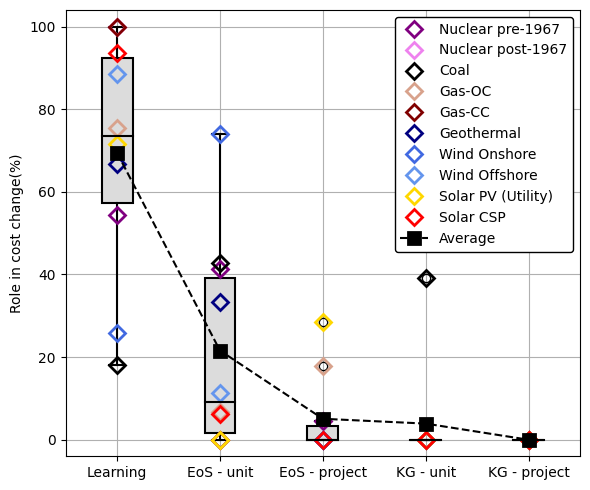

In [16]:
colors = ['purple','violet','black','#d8a28c','#800000',
          'navy','royalblue','cornflowerblue',
          'gold','red']

print("Roles of Different factors")

fig, ax = plt.subplots(figsize=(6,5))
ax.boxplot(pct_roles, widths=0.3,
           patch_artist=True, 
           medianprops={"color": "black", "linewidth": 1.5},
           boxprops={"facecolor": "gainsboro", "edgecolor": "black","linewidth": 1.5},
           whiskerprops={"color": "black", "linewidth": 1.5},
           capprops={"color": "black", "linewidth": 1.5})

for f in range(len(pct_roles.columns)):
    for t in range(len(pct_roles.index)):
        ax.plot(f+1,pct_roles.iloc[t,f],
                marker='D',ms=8,mew=2,mfc='none',
                lw=0,color=colors[t],
                label=pct_roles.index[t] if f == 0 else None
               )

xticks = ['Learning','EoS - unit','EoS - project','KG - unit','KG - project']

ax.plot([*range(1,len(xticks)+1)],pct_roles.mean(),marker='s',ms=8,mew=2,lw=1.5,ls='--',color='black',label='Average')

ax.grid(True)
ax.set_ylabel('Role in cost change(%)')
ax.set_ylim(-4,104)
ax.set_xticklabels(xticks)
legend = plt.legend(ncol=1,frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_alpha(1)
plt.tight_layout()
plt.savefig('figure/fig2_roles.jpg',dpi=600,transparent=True)
plt.show()

# Historical data fitting comparison

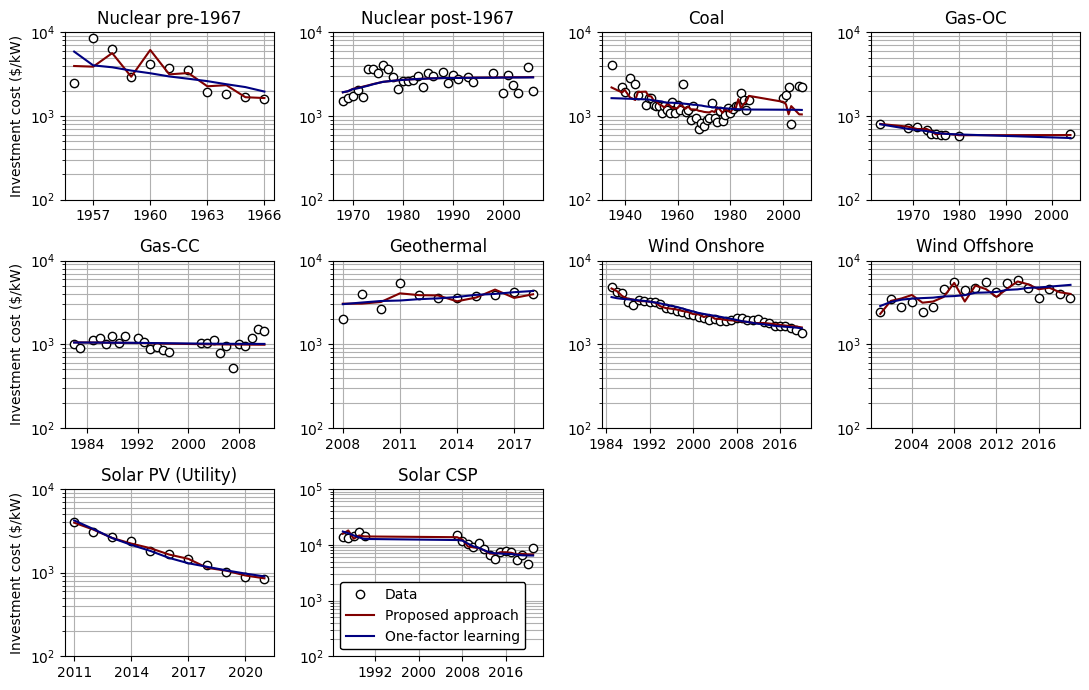

In [17]:
feat_errors = {tech: [] for tech in technologies}

approach_colors = ['navy','maroon','black']
names  = ['One-factor learning','Proposed approach','2KG']
fig, axs = plt.subplots(nrows=3,ncols=4, sharex=False, figsize=(11,7))
t = 0
for k,v in data.items():
    for k1,v1 in v.items():
        r = int(np.floor(t/4))
        c = t - r*4
        t = t+1
        
        df               = data[k][k1].copy()
        year             = df.index
        log_cum_capacity = df['Log_normRef_Cumulative Capacity']
        log_nbr_unit     = df['Log_normRef_Cumulative Units']
        log_sze_unit     = df['Log_normRef_Unit Size']
        log_sze_project  = df['Log_normRef_Project Size']
        log_sze_diffu    = df['Cumulative Log_Cunit']
        log_sze_diffp    = df['Cumulative Log_Cproject']
        
        data_plot = axs[r,c].plot(year, df['Capex'], c='black', lw=0, marker='o', mfc='white', label='Data')


        # granular one-factor learning with separated unit and project 2
        icref  = goflpars[k1][0]
        alpha  = goflpars[k1][1]
        betau  = goflpars[k1][3] if goflpars[k1][3] != 'N/A' else 0
        betap  = goflpars[k1][4]

        est = [10**(np.log10(icref)
               - alpha*log_nbr_unit[x] 
               - betau*log_sze_unit[x]
               - betap*log_sze_project[x]
               + betau*log_sze_diffu[x]
               + betap*log_sze_diffp[x])
               for x in year]

        est_plot = axs[r,c].plot(year, est, color='maroon', label='Proposed approach')

        
        # one-factor learning with separated unit and project 2
        icref  = df_1flrate.loc[k1,'Capex ref.']
        alpha  = df_1flrate.loc[k1,'Learning par.']
        
        est = [10**(np.log10(icref) - alpha*log_cum_capacity[x]) for x in year]

        est_plot = axs[r,c].plot(year, est, color='navy', label='One-factor learning')

        axs[r,c].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
        axs[r,c].set_yscale('log')
        axs[r,c].set_title(k1)
        axs[r,c].grid(True,'both')
        if c == 0:
            axs[r,c].set_ylabel('Investment cost ($/kW)')
        if k1 == 'Solar CSP':
            axs[r,c].set_ylim(100,100000)
            legend = axs[r,c].legend(ncol=1, frameon=True)
        else:
            axs[r,c].set_ylim(100,10000)
            
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_alpha(1)
axs[2,2].axis('off')
axs[2,3].axis('off')


plt.tight_layout()
fig.savefig('figure/fig4_comparison.jpg', dpi=600, transparent=True)
plt.show()
